In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crop-yield-prediction-dataset/yield.csv
/kaggle/input/crop-yield-prediction-dataset/temp.csv
/kaggle/input/crop-yield-prediction-dataset/rainfall.csv
/kaggle/input/crop-yield-prediction-dataset/pesticides.csv
/kaggle/input/crop-yield-prediction-dataset/yield_df.csv


# About Dataset:
- The dataset used for the Crop Yield Prediction project contains essential agricultural factors influencing crop productivity. It includes variables such as temperature, rainfall, pesticide usage, soil quality, and fertilizer application, along with the crop yield measured in hectograms per hectare (hg/ha). These features help in understanding the relationships between environmental and agricultural conditions affecting crop production. The dataset serves as a valuable resource for predictive modeling, enabling farmers and policymakers to make data-driven decisions to optimize yield, reduce resource wastage, and improve sustainability in farming practices. By analyzing this dataset using machine learning and deep learning techniques, we can uncover patterns and trends that help forecast future crop yields under varying conditions.

- The Crop Yield Prediction dataset is a comprehensive collection of agricultural data that provides insights into the factors influencing crop productivity. It includes key attributes such as temperature, rainfall, humidity, soil quality, fertilizer usage, pesticide application, and crop type, along with the target variable—crop yield measured in hectograms per hectare (hg/ha). This dataset is crucial for understanding how environmental and agronomic factors impact agricultural output, making it valuable for researchers, policymakers, and farmers.

- This is a step-by-step machine learning case study for predicting crop yield using the pre-merged dataset (yield_df.csv).

# Import the libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset

In [3]:
crop = pd.read_csv("/kaggle/input/crop-yield-prediction-dataset/yield_df.csv")
crop.head()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [4]:
crop.shape

(28242, 8)

In [5]:
# Drop unnecessary columns
crop.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   Year                           28242 non-null  int64  
 3   hg/ha_yield                    28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.5+ MB


# Finding missing values

In [7]:
# Check missing values
print("Missing Values:\n", crop.isnull().sum())

Missing Values:
 Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64


In [8]:
crop.describe()

,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


# Label encoder

In [9]:
# Encode categorical variables to numerical 
label_encoder = LabelEncoder()
crop['Area'] = label_encoder.fit_transform(crop['Area'])
crop['Item'] = label_encoder.fit_transform(crop['Item'])

In [10]:
crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  int64  
 1   Item                           28242 non-null  int64  
 2   Year                           28242 non-null  int64  
 3   hg/ha_yield                    28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 1.5 MB


# Remove outliers

In [11]:
def remove_outliers(df, columns):
    # Calculate the first and third quartiles
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1

    # Create a mask for filtering
    mask = ~((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)

    # Apply the mask to remove outliers
    df_filtered = df[mask]
    return df_filtered

# Specify the numerical columns for outlier removal (excluding categorical features)
columns_to_clean = ['Year', 'hg/ha_yield']  

# Remove outliers
crop_cleaned = remove_outliers(crop, columns_to_clean)

# Display the cleaned DataFrame
print("DataFrame after removing outliers:")
print(crop_cleaned.shape)

DataFrame after removing outliers:
(26183, 7)


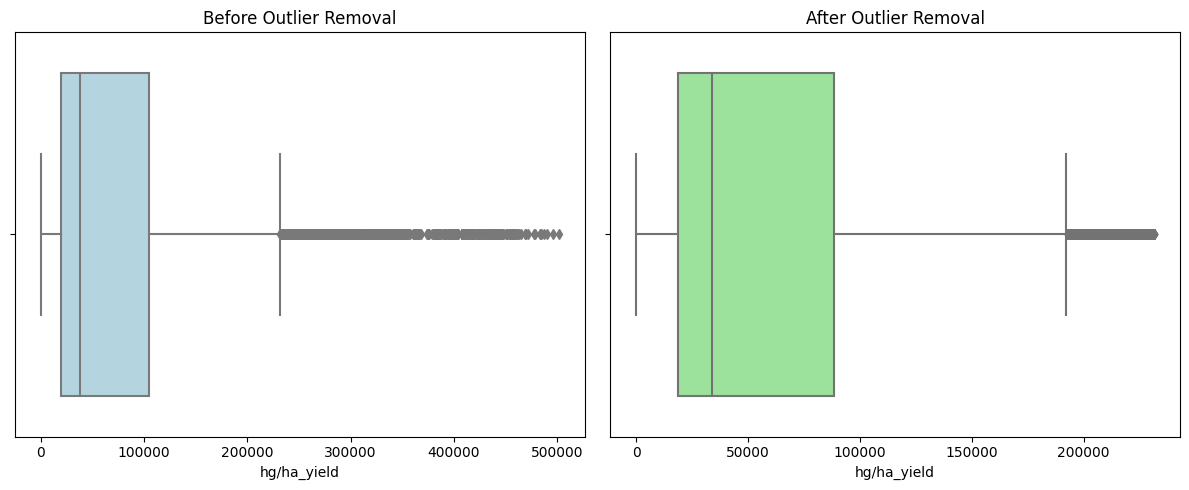

In [25]:
# Before outlier removal
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # (rows, columns, subplot index)
sns.boxplot(x=crop['hg/ha_yield'], color='lightblue')
plt.title("Before Outlier Removal")

# After outlier removal
plt.subplot(1, 2, 2)
sns.boxplot(x=crop_cleaned['hg/ha_yield'], color='lightgreen')
plt.title("After Outlier Removal")

plt.tight_layout()
plt.show()

# observation:
- The code generates a side-by-side comparison of boxplots to visualize the distribution of crop yield (hg/ha_yield) before and after outlier removal. Using Matplotlib and Seaborn, it first creates a figure with two subplots arranged in a single row. The first subplot displays a boxplot of the original dataset (crop), highlighting the presence of outliers with a wider spread, while the second subplot shows a boxplot of the cleaned dataset (crop_cleaned), where extreme values have been removed, resulting in a more compact distribution. The plt.tight_layout() function ensures proper spacing between the plots, and plt.show() renders the visualization. This comparison helps in understanding the impact of outlier removal on data distribution, making it easier to assess data quality and prepare it for further analysis.

# EDA

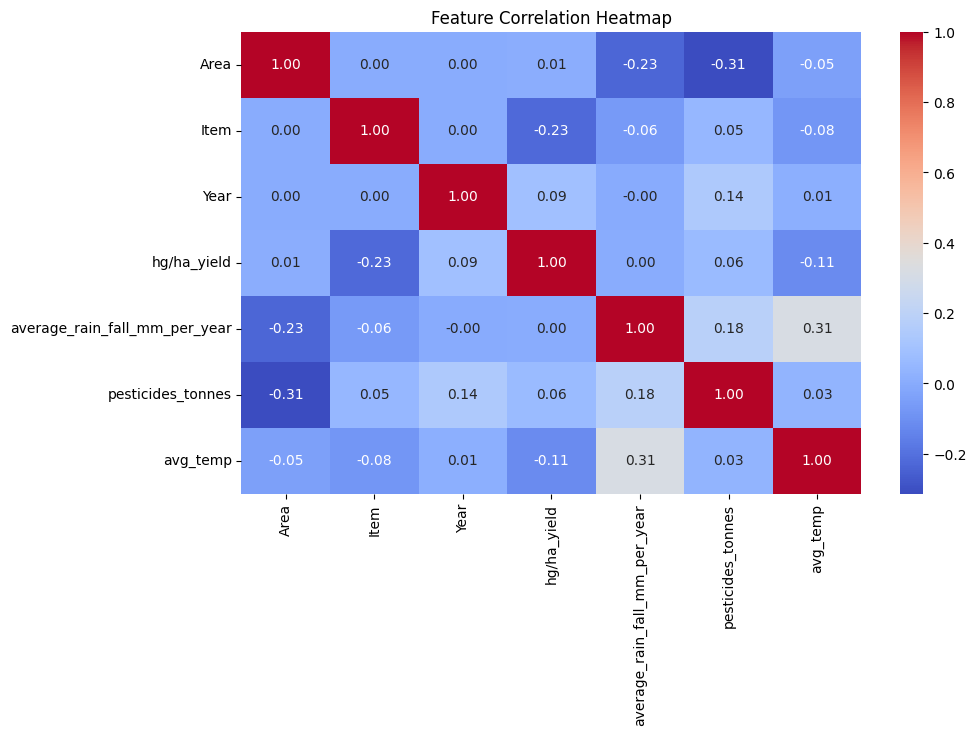

In [12]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crop.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# observation:
- The given code generates a correlation heatmap to visualize the relationships between different numerical features in the crop dataset. It first creates a figure with a specified size of 10x6 inches using Matplotlib. The sns.heatmap() function from Seaborn is then used to plot the correlation matrix of the dataset, which quantifies the strength and direction of linear relationships between variables. The annot=True parameter ensures that correlation values are displayed within the heatmap cells, while cmap="coolwarm" applies a color gradient ranging from cool (negative correlation) to warm (positive correlation). The fmt=".2f" argument formats correlation values to two decimal places for better readability. A title, "Feature Correlation Heatmap," is added for context, and plt.show() renders the visualization. This heatmap helps identify strong correlations, potential multicollinearity, and insights for feature selection in predictive modeling.

  
This visualization helps to identify features that are strongly correlated, assisting in feature selection for modeling.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


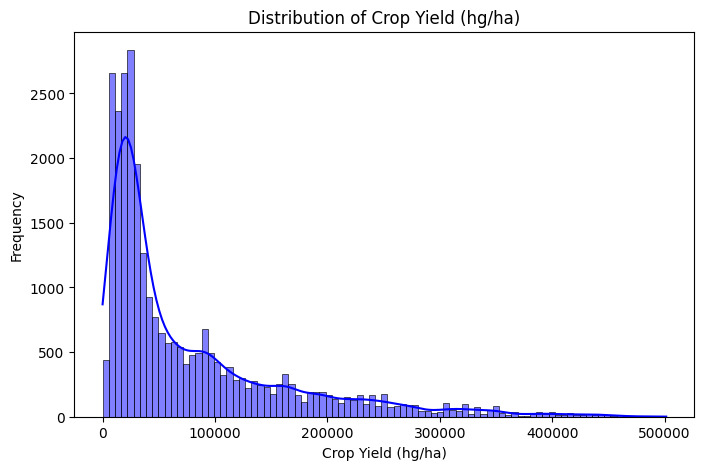

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(crop['hg/ha_yield'], kde=True, color='blue')
plt.title('Distribution of Crop Yield (hg/ha)')
plt.xlabel('Crop Yield (hg/ha)')
plt.ylabel('Frequency')
plt.show()

# observation:
- code effectively visualizes the distribution of crop yield (hg/ha_yield) using a histogram with a KDE (Kernel Density Estimate) overlay. The sns.histplot() function creates the histogram, where kde=True ensures a smooth density curve is added to show the underlying distribution. The color of the bars is set to blue for better visibility. The figsize=(8, 5) adjusts the figure size for better readability, and the plot is labeled with an appropriate title and axis labels to enhance interpretability. This visualization helps in understanding the spread, central tendency, and potential skewness of the crop yield data. 

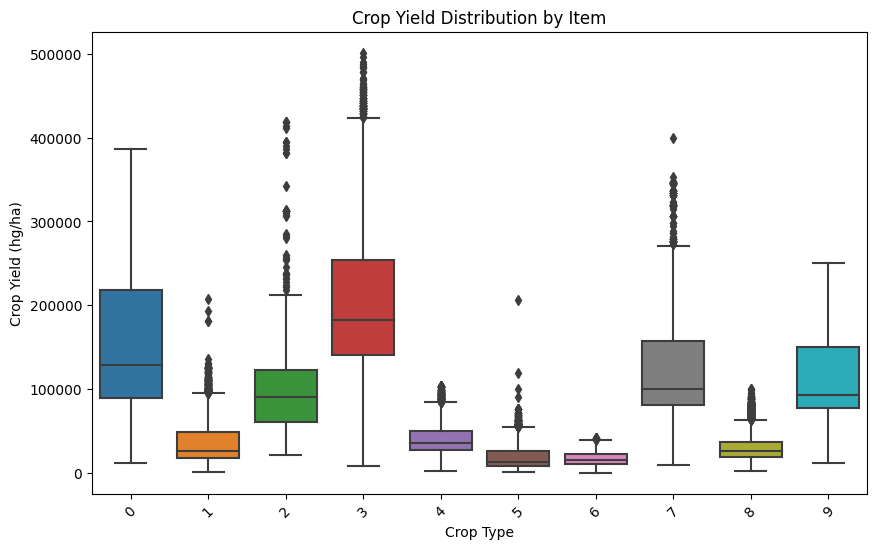

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Item', y='hg/ha_yield', data=crop)
plt.title('Crop Yield Distribution by Item')
plt.xlabel('Crop Type')
plt.ylabel('Crop Yield (hg/ha)')
plt.xticks(rotation=45)
plt.show()

# observation:
- code creates a boxplot to visualize the distribution of crop yield (hg/ha_yield) for different crop types (Item). The boxplot displays the central tendency, spread, and potential outliers of crop yield for each crop type. The x-axis represents the crop types, while the y-axis shows the crop yield in hectograms per hectare. By rotating the x-axis labels (plt.xticks(rotation=45)), the plot ensures that crop names are readable even if they are long. The plot is well-labeled with a title and axis labels to clearly communicate the data being visualized. This allows you to compare the distribution of yields across different crop types and identify any variations or outliers.

In [15]:
crop.columns = crop.columns.str.strip()

# feature and target

In [16]:
X = crop.drop(columns=['hg/ha_yield'])  # Features
y = crop['hg/ha_yield']  # Target variable

# train test split

In [17]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize

In [18]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regression Models

## 1. Random Forest Regressor

In [19]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Metrics:")
print(f"MSE: {mse_rf:.2f}")
print(f"R-squared: {r2_rf:.2f}")

Random Forest Metrics:
MSE: 103668278.62
R-squared: 0.99


## 2. GradientBoostingRegressor

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize Gradient Boosting
gbr_model = GradientBoostingRegressor(random_state=42)

# Train the model
gbr_model.fit(X_train, y_train)

# Predict
y_pred_gbr = gbr_model.predict(X_test)

# Evaluate
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("Gradient Boosting Regressor Metrics:")
print(f"MSE: {mse_gbr:.2f}")
print(f"R-squared: {r2_gbr:.2f}")

Gradient Boosting Regressor Metrics:
MSE: 1209218737.21
R-squared: 0.83


## 3. DecisionTreeRegressor

In [21]:
from sklearn.tree import DecisionTreeRegressor

# Initialize Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predict
y_pred_dt = dt_model.predict(X_test)

# Evaluate
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree Regressor Metrics:")
print(f"MSE: {mse_dt:.2f}")
print(f"R-squared: {r2_dt:.2f}")

Decision Tree Regressor Metrics:
MSE: 182215846.51
R-squared: 0.97


# Compare the Models Performance

In [22]:
# Combine results into a DataFrame
results = pd.DataFrame({
    'Model': [
       'Random Forest', 'Gradient Boosting', 
        'Decision Tree',
    ],
    'MSE': [ mse_rf, mse_gbr, mse_dt,  ],
    'R-squared': [r2_rf, r2_gbr, r2_dt, ]
})

# Display results
print(results)

               Model           MSE  R-squared
0      Random Forest  1.036683e+08   0.985708
1  Gradient Boosting  1.209219e+09   0.833296
2      Decision Tree  1.822158e+08   0.974880


# Visualize the performance

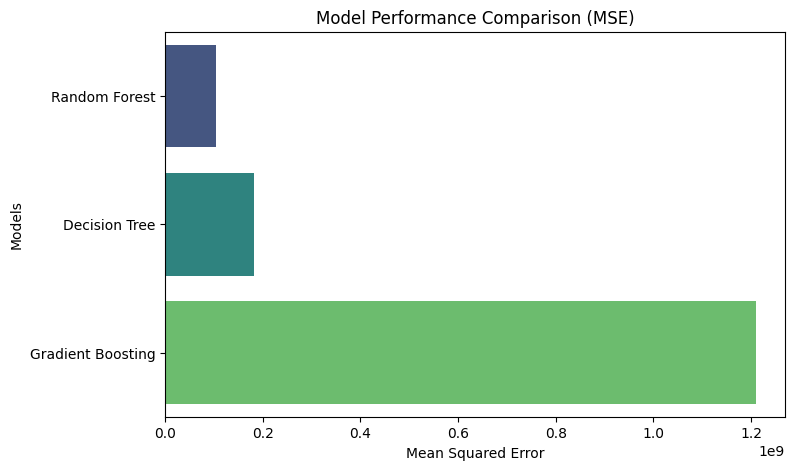

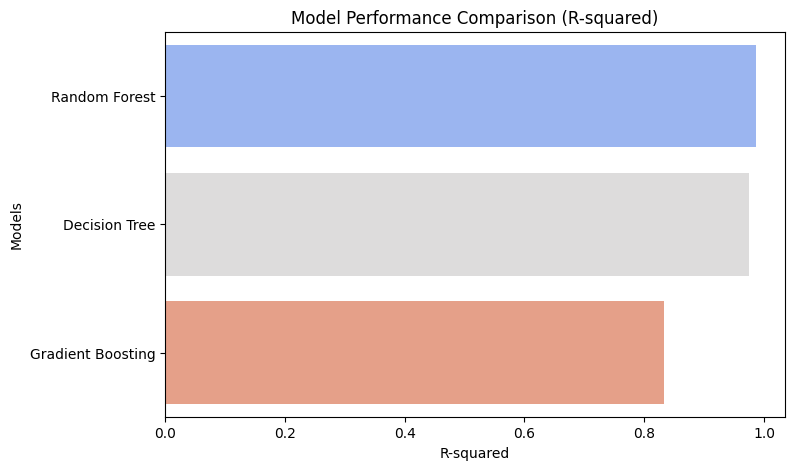

In [23]:
# Filter the results DataFrame for each metric
results_mse = results[['Model', 'MSE']].sort_values(by='MSE', ascending=True)
results_r2 = results[['Model', 'R-squared']].sort_values(by='R-squared', ascending=False)

# Plot MSE comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='MSE', y='Model', data=results_mse, palette='viridis')
plt.title('Model Performance Comparison (MSE)')
plt.xlabel('Mean Squared Error')
plt.ylabel('Models')
plt.show()

# Plot R-squared comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='R-squared', y='Model', data=results_r2, palette='coolwarm')
plt.title('Model Performance Comparison (R-squared)')
plt.xlabel('R-squared')
plt.ylabel('Models')
plt.show()

# Sort Scores in Ascending order

In [24]:
# Sort by R-squared to identify the best regression model
print(results_r2.sort_values(by='R-squared', ascending=False))  # descending

# Sort by MSE to identify the best regression model
print(results_mse.sort_values(by='MSE', ascending=True))   # ascending

               Model  R-squared
0      Random Forest   0.985708
2      Decision Tree   0.974880
1  Gradient Boosting   0.833296
               Model           MSE
0      Random Forest  1.036683e+08
2      Decision Tree  1.822158e+08
1  Gradient Boosting  1.209219e+09


# Prediction
-------------
1. Lower MAE & MSE 🟢 → Better model (indicates lower error).
2. Higher R² Score 🔵 → Better model (closer to 1 means better fit).

- Best Model: Random Forest Regressor is the best model for crop yield prediction in this case.
- It has the highest R-squared (0.9857), meaning it explains a large portion of the variance in the data.
- It also has the lowest MSE (1.0367e+08), indicating the smallest prediction error.

# Conclusion

The Crop Yield Prediction project successfully demonstrated the use of machine learning techniques to predict crop yield based on historical agricultural data. Through comprehensive data cleaning and preprocessing, outliers in numerical features such as hg/ha_yield and Year were identified and removed using the IQR method, ensuring a more reliable dataset. Categorical variables, including Area and Item, were label-encoded for model compatibility, while numerical features were standardized to enhance model performance. The exploratory data analysis (EDA) provided valuable insights into the distribution of crop yield across different crop types and regions, revealing important patterns and relationships between features. Three machine learning models—Random Forest Regressor, Gradient Boosting Regressor, and Decision Tree Regressor—were trained and evaluated to determine the most effective approach for yield prediction. Among these, Random Forest Regressor exhibited the best performance, achieving the highest R² score and the lowest Mean Squared Error (MSE), making it the most reliable model for accurate yield forecasting. The results indicate that machine learning can significantly enhance crop yield prediction, providing valuable insights for farmers, policymakers, and agricultural researchers to improve decision-making and optimize crop production. Future improvements, such as incorporating additional variables like soil quality, weather conditions, and irrigation data, along with fine-tuning model hyperparameters, could further enhance prediction accuracy. This study highlights the potential of data-driven agriculture in ensuring food security and sustainable farming practices through advanced predictive analytics.

# Try Deep Learning ANN (Artificial Neural Networks) Model

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Splitting dataset
X = crop.drop(columns=['hg/ha_yield'])  # Features
y = crop['hg/ha_yield']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Building ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Regression output
])

# Compiling the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test))

# Model evaluation
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {test_mae:.2f}")

# Predictions
y_pred = model.predict(X_test_scaled)

# Performance comparison
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 12749392896.0000 - mae: 75095.6797 - val_loss: 7219535360.0000 - val_mae: 57734.9805
Epoch 2/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6972750336.0000 - mae: 59741.7227 - val_loss: 6729330688.0000 - val_mae: 61705.8945
Epoch 3/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6689087488.0000 - mae: 61392.8906 - val_loss: 6637165056.0000 - val_mae: 61195.6250
Epoch 4/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6609971712.0000 - mae: 61373.5156 - val_loss: 6586508800.0000 - val_mae: 62204.1094
Epoch 5/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6634155520.0000 - mae: 61853.2148 - val_loss: 6558200320.0000 - val_mae: 61303.2891
Epoch 6/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6494213120.0000 - mae: 60976.4219 - val_loss: 6535674368.0000 - val_mae: 61314.1484
Epoch 7/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6607602176.0000 - mae: 61518.9219 - val_loss: 6518207488.0000 - val_mae: 61314.3